## Download and Import Library

Download Library

In [20]:
!pip install tensorflow_decision_forests
!pip install colabtools

Import Library

In [21]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math

try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

from IPython.core.magic import register_line_magic
from IPython.display import Javascript
# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

Found TensorFlow Decision Forests v1.11.0


# Data Preparation

## **Download Dataset**

---

- PalmerPenguin là bộ dữ liệu phân loại giống loài chim cánh cụt bao gồm các phép đo kích thước của 3 loài chim cánh cụt được quan sát trên 3 hòn đảo ở quần đảo Palmer, Nam Cực.
- Dựa trên mô hình Random Forest, ta sẽ huấn luyện bộ dữ liệu để xác định giống loài chim cánh cụt dựa trên các kích thước đã cho.

In [22]:
# Download the dataset
!wget -q https://storage.googleapis.com/download.tensorflow.org/data/palmer_penguins/penguins.csv -O /tmp/penguins.csv

# Load a dataset into a Pandas Dataframe.
dataset_df = pd.read_csv("/tmp/penguins.csv")

# Display the first 3 examples.
dataset_df.head(3)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007


## **Data description**

---
- Mục đích của mô hình là đưa ra dự đoán về giống loài của chim cánh cụt dựa trên kích thước đã cho, nên species sẽ là nhãn của mô hình. Chuẩn hoá label từ String thành Integers vì Tensorflow - Keras mong đợi nhãn sẽ là Integers.
- Để mô hình thêm chính xác ta chia bộ dữ liệu với tỉ lệ < 30% dataset để test, phần còn lại để train.
- Vì ta huấn luyện mô hình trên Tensorflow nên ta chuyển dữ liệu từ DataFrame thành Tensorflow Datasets.


In [23]:

# Name of the label column.
label = "species"

classes = dataset_df[label].unique().tolist()
print(f"Label classes: {classes}")

dataset_df[label] = dataset_df[label].map(classes.index)

Label classes: ['Adelie', 'Gentoo', 'Chinstrap']


In [24]:
# Split the dataset into a training and a testing dataset.

def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]


train_ds_pd, test_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

239 examples in training, 105 examples for testing.


In [25]:
# Change DataFrame Structure into Tensorflow Dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label)

# Build And Train Random Forest Model

Build Model

---

- Mô hình được build trên Tensorflow Random Forest, một thư viện huấn luyện mô hình Random Forest cơ bản, cho ra hiệu suất tốt và độ chính xác cao.

- Biên dịch mô hình với accuracy ghi lại độ chính xác qua mỗi lần huấn luyện.


---

Train Model


---

- Huấn luyện mô hình với tập huấn luyện là *train_ds*.

In [26]:

# Specify the model.
model_1 = tfdf.keras.RandomForestModel()

# Optionally, add evaluation metrics.
model_1.compile(
    metrics=["accuracy"])

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
  model_1.fit(x=train_ds)

Use /tmp/tmp694jjwqc as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.253267. Found 239 examples.
Training model...


I0000 00:00:1733300613.201535     202 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1733300613.201584     202 kernel.cc:783] Collect training examples
I0000 00:00:1733300613.201603     202 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1733300613.201770     202 kernel.cc:401] Number of batches: 1
I0000 00:00:1733300613.201782     202 kernel.cc:402] Number of examples: 239
I0000 00:00:1733300613.201928     202 kernel.cc:802] Training dataset:
Number of records: 239
Number of columns: 8

Number of columns by type:
	NUMERICAL: 5 (62.5%)
	CATEGORICAL: 3 (37.5%)

Columns:

NUMERICAL: 5 (62.5%)
	1: "bill_depth_mm" NUMERICAL num-nas:2 

Model trained in 0:00:00.188353
Compiling model...
Model compiled.


# Evaluate Model

In [27]:
evaluation = model_1.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

model_1.save("/tmp/my_saved_model")

1/1 [==============================] - 0s 150ms/step - loss: 0.0000e+00 - accuracy: 0.9905

loss: 0.0000
accuracy: 0.9905


**Evaluate**

---
- Mô hình cho ra kết quả khả quan, độ chính xác cao.
- Qua quá trình huấn luyện cho thấy mô hình được huấn luyện rất tốt.

# Draw Plot and Model

## Draw Model after Trainning.

In [28]:
tfdf.model_plotter.plot_model_in_colab(model_1, tree_idx=0, max_depth=3)

## Save Training Logs

---
- Training Logs cho thấy mô hình huấn luyện khá kỹ, độ sai sót thấp, có thể ứng dụng cho thực tế.

In [30]:
model_1.make_inspector().training_logs()

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=88, accuracy=0.9545454545454546, loss=1.6383477991277522, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=11, evaluation=Evaluation(num_examples=238, accuracy=0.957983193277311, loss=0.3792631826480898, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=21, evaluation=Evaluation(num_examples=239, accuracy=0.9497907949790795, loss=0.3794290961767839, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=31, evaluation=Evaluation(num_examples=239, accuracy=0.9581589958158996, loss=0.23206679900196306, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=41, evaluation=Evaluation(num_examples=239, accuracy=0.9623430962343096, loss=0.23232802249896475, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=51, evaluation=Evaluation(num_examples=239, accuracy=0.9707112970711297, loss=0.2316845347909997, rmse=Non

## Draw Plot Training Logs.

---
- Thông qua đồ thị cho thấy mô hình được huấn luyện khá tốt.
- Không có tình trạng overfiting hay underfiting.

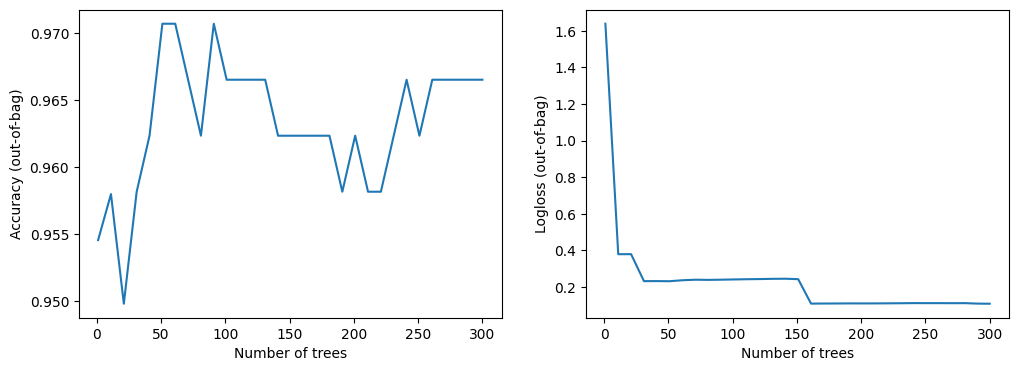

In [31]:
import matplotlib.pyplot as plt

logs = model_1.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()